In [1]:
from data_utils import straitified_train_validation_split, dataloader
from model import BillNet
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

## Read in and prepare data

In [2]:
#Old data test
#bert_train = torch.load('data/processed/bert_data.pt')
#labels_train = np.load('data/processed/targets_sent_train.npy')
#labels_valid = np.load('data/processed/targets_sent_valid.npy')
#labels = np.hstack((labels_train, labels_valid))
#labels_train = torch.tensor(labels, dtype= torch.long)

In [3]:
bert_train = torch.load('data/bert_train_103-114.pt')

In [4]:
labels_train = torch.load('data/labels_train_103-114.pt')

In [5]:
#all_id = np.load('data/all_id.npy')

In [6]:
bert_train, labels_train, bert_val, labels_val = straitified_train_validation_split(bert_train, 
                                                                                   labels_train)
class_weights=compute_class_weight('balanced', classes = np.unique(labels_train.numpy()),
                                   y = labels_train.numpy())
class_weights=torch.tensor(class_weights,dtype=torch.float)
train_dataloader = dataloader(bert_train, labels_train, batch_size=64)
valid_dataloader = dataloader(bert_val, labels_val, batch_size=64)


In [7]:
del bert_train, bert_val, labels_train, labels_val

## CNN for the N x S x K embeddings

In [8]:
train_dataloader.dataset.targets[train_dataloader.dataset.targets==1].shape

torch.Size([573])

In [9]:
valid_dataloader.dataset.targets[valid_dataloader.dataset.targets==1].shape

torch.Size([143])

In [11]:
net = BillNet(num_classes = 2)
#net = net.cuda()
print(net)

BillNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6624, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=2, bias=True)
)


In [13]:
optimizer = optim.Adam(net.parameters(), lr=0.001, 
                       weight_decay=0.01)
max_epochs = 5
#criterion = nn.CrossEntropyLoss(weight=class_weights.cuda())
criterion = nn.CrossEntropyLoss(weight=class_weights)
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

In [14]:
train_acc = []
losses = []
val_recall_scores = []
# Loop over epochs
for epoch in range(max_epochs):
    # Training
    train_preds, train_targs = [], []
    cur_loss = 0.0
    net.train()
    training_loop = tqdm(iter(train_dataloader), leave=True)
    for local_batch, local_labels in training_loop:
        # Zero gradient
        optimizer.zero_grad()
        # Transfer to GPU
        local_batch = local_batch.to(device, dtype=torch.float)
        local_labels = local_labels.to(device, dtype=torch.long)
        # zero the parameter gradients
       
        # Model computations
        output = net(local_batch)
        batch_loss = criterion(output, local_labels)
        batch_loss.backward()
        optimizer.step()
        training_loop.set_description(f'Epoch {epoch+1}')
        training_loop.set_postfix(loss=batch_loss.item())
        cur_loss += batch_loss
        # Get predictions
        predicted = torch.max(output, 1)[1]
        train_targs += list(local_labels.cpu().numpy())
        train_preds += list(predicted.data.cpu().numpy())
    
    print('-----------Training Metrics-----------')
    print('Accuracy: {}'.format(accuracy_score(train_targs, train_preds)))
    print('F1: {}'.format(f1_score(train_targs, train_preds)))
    print('Precision: {}'.format(precision_score(train_targs, train_preds)))
    print('Recall: {}'.format(recall_score(train_targs, train_preds)))
    print('Confusion Matrix:')
    print(confusion_matrix(train_targs, train_preds))

    # Validation
    net.eval()
    val_preds, val_targs = [], []
    probas = []
    with torch.no_grad():
        for local_batch, local_labels in valid_dataloader:
            local_batch = local_batch.to(device, dtype=torch.float)
            local_labels =  local_labels.to(device, dtype=torch.long)
            outputs = net(local_batch)
            predicted = torch.max(outputs.data, 1)[1]
            probas += list(outputs.data.cpu().numpy()[:,1])
            val_targs += list(local_labels.cpu().numpy())
            val_preds += list(predicted.data.cpu().numpy())
    
    lr_fpr, lr_tpr, _ = roc_curve(val_targs, probas)
    print('-----------Validation Metrics-----------')
    print('Accuracy: {}'.format(accuracy_score(val_targs, val_preds)))
    print('F1: {}'.format(f1_score(val_targs, val_preds)))
    print('Precision: {}'.format(precision_score(val_targs, val_preds)))
    print('Recall: {}'.format(recall_score(val_targs, val_preds)))
    print('Confusion Matrix:')
    print(confusion_matrix(val_targs, val_preds))
    print('-' * 66)

Epoch 1: 100%|██████████████████████████████████████████████████████████| 259/259 [24:50<00:00,  5.75s/it, loss=0.0929]


-----------Training Metrics-----------
Accuracy: 0.8248188405797101
F1: 0.218691085375707
Precision: 0.12929936305732484
Recall: 0.7085514834205934
Confusion Matrix:
[[13253  2734]
 [  167   406]]
-----------Validation Metrics-----------
Accuracy: 0.9794735571118087
F1: 0.7521865889212828
Precision: 0.645
Recall: 0.9020979020979021
Confusion Matrix:
[[3927   71]
 [  14  129]]
------------------------------------------------------------------


Epoch 2: 100%|███████████████████████████████████████████████████████████| 259/259 [21:17<00:00,  4.93s/it, loss=0.372]


-----------Training Metrics-----------
Accuracy: 0.9867753623188406
F1: 0.8226720647773279
Precision: 0.7673716012084593
Recall: 0.8865619546247818
Confusion Matrix:
[[15833   154]
 [   65   508]]
-----------Validation Metrics-----------
Accuracy: 0.9744023182806085
F1: 0.7087912087912088
Precision: 0.583710407239819
Recall: 0.9020979020979021
Confusion Matrix:
[[3906   92]
 [  14  129]]
------------------------------------------------------------------


Epoch 3: 100%|██████████████████████████████████████████████████████████| 259/259 [23:25<00:00,  5.43s/it, loss=0.0414]


-----------Training Metrics-----------
Accuracy: 0.9890700483091788
F1: 0.849792531120332
Precision: 0.810126582278481
Recall: 0.893542757417103
Confusion Matrix:
[[15867   120]
 [   61   512]]
-----------Validation Metrics-----------
Accuracy: 0.9963776865491427
F1: 0.9450549450549451
Precision: 0.9923076923076923
Recall: 0.9020979020979021
Confusion Matrix:
[[3997    1]
 [  14  129]]
------------------------------------------------------------------


Epoch 4: 100%|██████████████████████████████████████████████████████████| 259/259 [26:38<00:00,  6.17s/it, loss=0.0414]


-----------Training Metrics-----------
Accuracy: 0.9807971014492753
F1: 0.7609022556390976
Precision: 0.6684280052840158
Recall: 0.8830715532286213
Confusion Matrix:
[[15736   251]
 [   67   506]]
-----------Validation Metrics-----------
Accuracy: 0.9934798357884569
F1: 0.9052631578947369
Precision: 0.9084507042253521
Recall: 0.9020979020979021
Confusion Matrix:
[[3985   13]
 [  14  129]]
------------------------------------------------------------------


Epoch 5: 100%|██████████████████████████████████████████████████████████| 259/259 [23:57<00:00,  5.55s/it, loss=0.0539]


-----------Training Metrics-----------
Accuracy: 0.980012077294686
F1: 0.7546330615270571
Precision: 0.6559278350515464
Recall: 0.8883071553228621
Confusion Matrix:
[[15720   267]
 [   64   509]]
-----------Validation Metrics-----------
Accuracy: 0.9794735571118087
F1: 0.7507331378299121
Precision: 0.6464646464646465
Recall: 0.8951048951048951
Confusion Matrix:
[[3928   70]
 [  15  128]]
------------------------------------------------------------------


In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

In [20]:
lr_precision, lr_recall, _ = precision_recall_curve(val_targs, probas)

In [21]:
lr_precision.shape

(3880,)

In [42]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

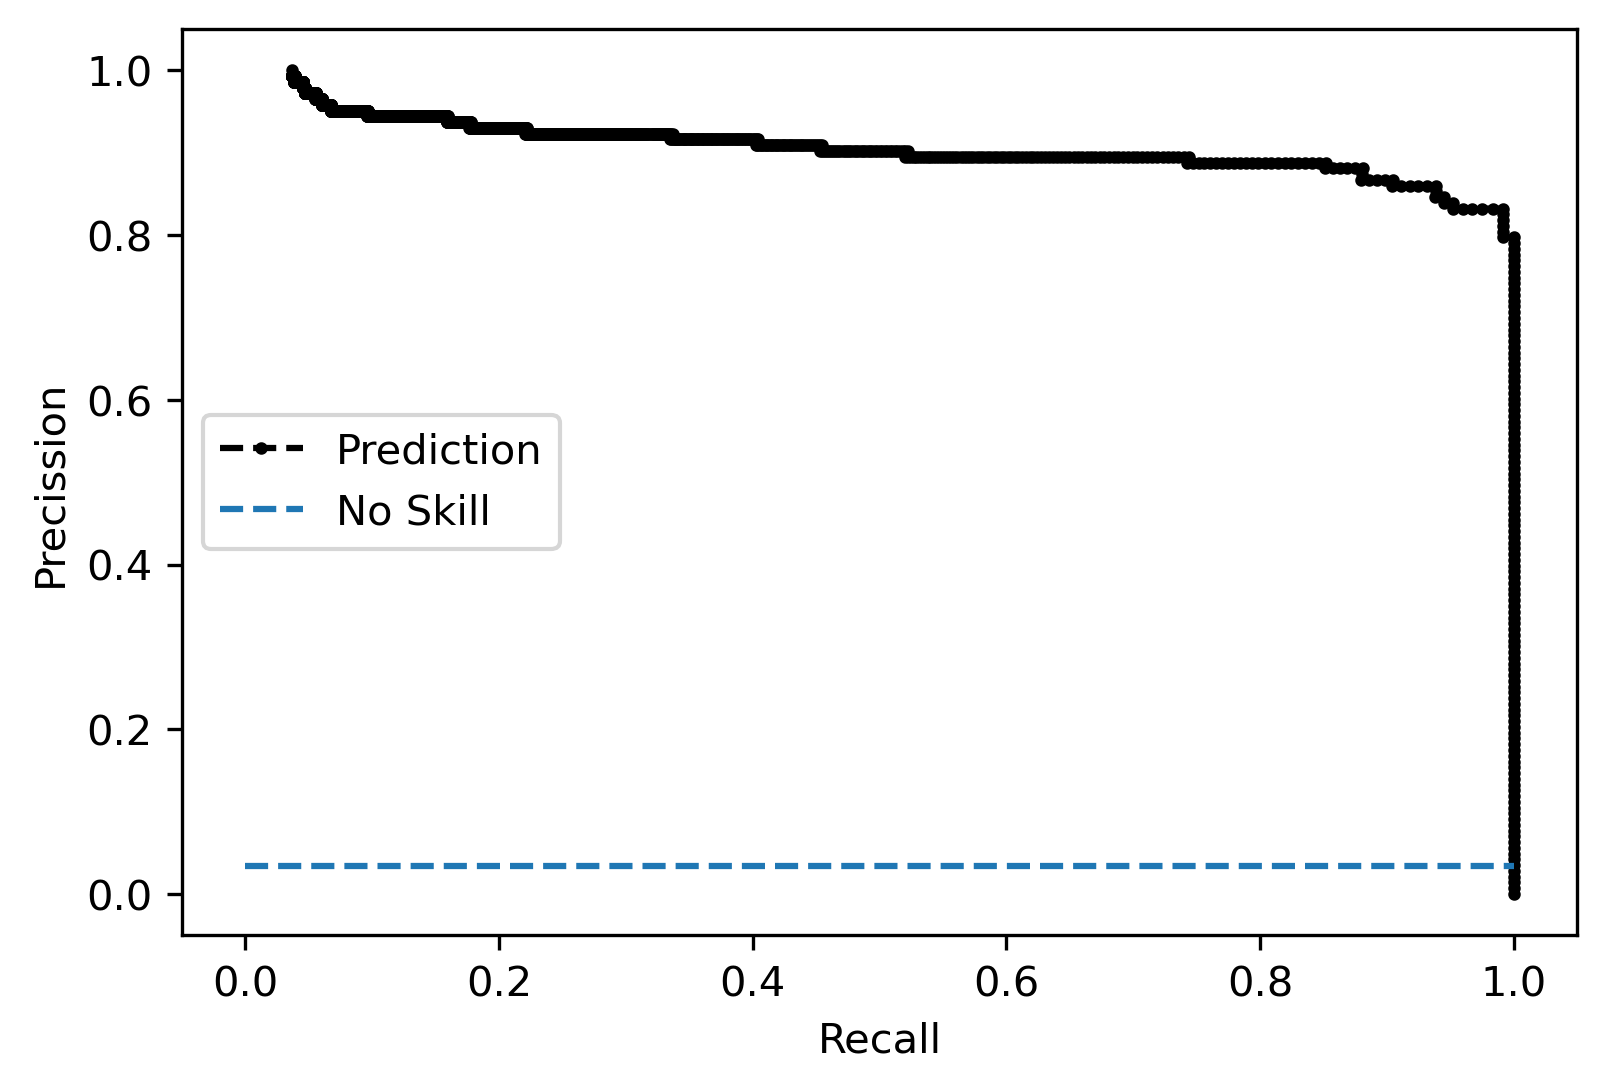

In [43]:
fig, ax = plt.subplots(dpi = 300)
#with plt.style.context('science'):
ax.plot(lr_precision, lr_recall, 'ko--', markersize=2, label='Prediction')
no_skill = len([t for t in val_targs if t ==1]) / len(val_targs)
ax.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
ax.set_xlabel('Recall')
ax.set_ylabel('Precission')
ax.legend()

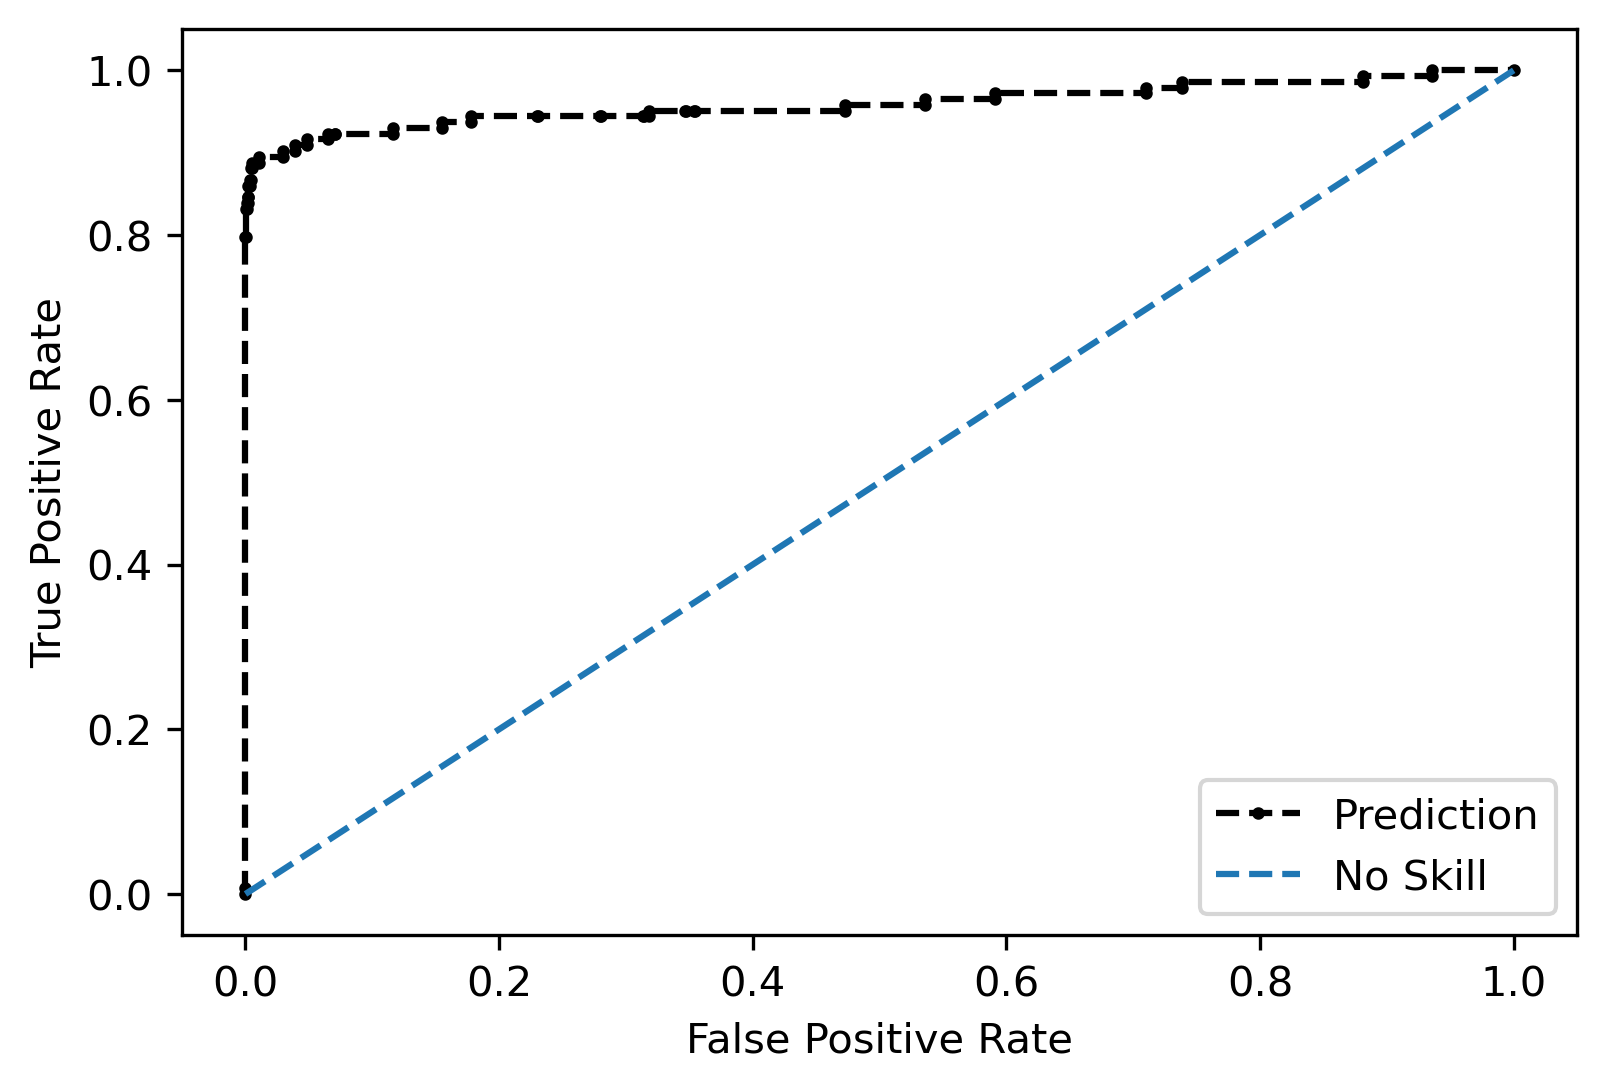

In [44]:
fig, ax = plt.subplots(dpi = 300)
ns_probs = [0 for _ in range(len(val_targs))]
ns_fpr, ns_tpr, _ = roc_curve(val_targs, ns_probs)
#with plt.style.context('science'):
ax.plot(lr_fpr, lr_tpr, 'ko--', markersize=2, label='Prediction')
ax.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()

In [36]:
from sklearn.metrics import roc_auc_score


In [38]:
roc_auc_score(val_targs, val_preds)

0.9387980703638532

In [26]:
from sklearn.metrics import confusion_matrix
# Confusion matrix
conf_mat=confusion_matrix(val_targs, val_preds)
print(conf_mat)


[[3928   70]
 [  15  128]]


In [27]:
#torch.save(net.state_dict(), 'trained_model.obj')
#net = Net(num_classes = 2)
#net.load_state_dict(torch.load('trained_model.obj'))

## Test data

In [ ]:
#OLD
#import pandas as pd

#test_dataset = np.load('')
#test_dataset = test_dataset[:,None,:, :]
#test_labels = pd.read_pickle('data/processed/test_dat.pkl')
#bill_status = pd.read_csv('data/processed/bill_status.csv').rename({'bill':'bill_id'}, axis=1)
#test_labels = test_labels.merge(bill_status, on = 'bill_id', how='left')['status'].to_numpy()

In [31]:
test_dataset = torch.load('data/bert_test_115.pt')
test_labels = torch.load('data/labels_test_115.pt')

In [33]:
test_dataloader = dataloader(test_dataset, test_labels, batch_size=64)

In [34]:
#test_labels = pd.read_pickle('data/processed/test_dat.pkl')
#test_labels

In [35]:
net.eval()
test_preds, test_targs = [], []
with torch.no_grad():
    for local_batch, local_labels in test_dataloader:
        local_batch = local_batch.to(device, dtype=torch.float)
        local_labels =  local_labels.to(device, dtype=torch.long)
        outputs = net(local_batch)
        predicted = torch.max(outputs.data, 1)[1]
        test_targs += list(local_labels.cpu().numpy())
        test_preds += list(predicted.data.cpu().numpy())
print('-----------Test Metrics-----------')
print('Accuracy: {}'.format(accuracy_score(test_targs, test_preds)))
print('F1: {}'.format(f1_score(test_targs, test_preds)))
print('Precision: {}'.format(precision_score(test_targs, test_preds)))
print('Recall: {}'.format(recall_score(test_targs, test_preds)))
print(confusion_matrix(test_targs, test_preds))

-----------Test Metrics-----------
Accuracy: 0.9809052333804809
F1: 0.7522935779816514
Precision: 0.7454545454545455
Recall: 0.7592592592592593
[[1346   14]
 [  13   41]]


In [39]:
roc_auc_score(test_targs, test_preds)

0.8744825708061003

## Evaluate old model


In [ ]:
model = BillNet(2)
model.load_state_dict(torch.load('trained_model.obj'))
model.cuda()
model.eval()

In [ ]:
test_preds, test_targs = [], []

with torch.no_grad():
    for local_batch, local_labels in train_dataloader:
        local_batch = local_batch.to('cuda', dtype=torch.float)
        local_labels =  local_labels.to('cuda', dtype=torch.long)
        outputs = model(local_batch)
        predicted = torch.max(outputs.data, 1)[1]
        test_targs += list(local_labels.cpu().numpy())
        test_preds += list(predicted.data.cpu().numpy())
print('-----------Test Metrics-----------')
print('Accuracy: {}'.format(accuracy_score(test_targs, test_preds)))
print('F1: {}'.format(f1_score(test_targs, test_preds)))
print('Precision: {}'.format(precision_score(test_targs, test_preds)))
print('Recall: {}'.format(recall_score(test_targs, test_preds)))
print(confusion_matrix(test_targs, test_preds))